## Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import itertools
import math
from pprint import pprint
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder

# To execute a cell line by line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

# Bagging and Boosting

In this question, you will need to implement the boosting algorithm AdaBoost as well as a Bagging,
in both cases using decision trees as the base classifiers. You will then be asked to experiment with your
implementation on a number of provided datasets, and to write up a brief report on your findings. (Minor
note on terminology: Classifier means the same thing as hypothesis, and base classifier, in the context of
boosting, is exactly the same as a weak classifier.)


### 1) Adaboost with decision trees

The first part is that you need to write a function to implement the AdaBoost algorithm we discussed
in class. The input of your function is the training and test sets, as well as the number of rounds
of boosting T. It should then run AdaBoost for T rounds, using the decision-tree algorithm as the
base learner. The function should then return the predictions of the final combined classifier on the
given training and test examples, as well as the training and test error rate of the combined classifier
following each of the T rounds.


In [7]:
def errorCalc(y, y_pred, wts):
  error = (sum(wts * (np.not_equal(y, y_pred)).astype(int)))/sum(wts)
  return error

def alphaCalc(error):
  alpha = np.log((1 - error) / error)
  return alpha

def updatedWeightsCalc(wts, alpha, y, y_pred):
  updated_wts = wts * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))
  return updated_wts

def compute_error(y, y_pred, wts):
  return (sum(wts * (np.not_equal(y, y_pred)).astype(int)))/sum(wts)

In [8]:
def adaBoost(X, y, boost_rounds, max_depth):
  alpha = []
  all_clf = []
  train_error = []
  for i in range(boost_rounds):
    if i == 0:
      wts = np.ones(len(y)) * 1 / len(y)
    else:
      wts = updatedWeightsCalc(wts, alpha_val, y, y_pred)

    # Using decision tree as base learner
    clf = DecisionTreeClassifier(max_depth = max_depth)
    clf.fit(X, y, wts)
    y_pred = clf.predict(X)
    all_clf.append(clf)

    # Calculate error
    error_val = errorCalc(y, y_pred, wts)
    train_error.append(error_val)

    # Calculate alpha
    alpha_val = alphaCalc(error_val)
    alpha.append(alpha_val)

  return all_clf, train_error, alpha

In [9]:
def predict(X, boost_rounds, all_clf, alpha):
  weak_preds = pd.DataFrame(index = range(len(X)), columns = range(boost_rounds)) 
  for i in range(boost_rounds):
    y_pred_i = all_clf[i].predict(X) * alpha[i]
    weak_preds.iloc[:,i] = y_pred_i

  # Estimate final predictions
  y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

  return y_pred

In [10]:
def error_rates(X, y, boost_rounds, all_clf):
  prediction_errors = [] 
  # Predict class label for each weak classifier
  for i in range(boost_rounds):
    y_pred_i = all_clf[i].predict(X)          
    error_i = errorCalc(y, y_pred_i, np.ones(len(y)))
    prediction_errors.append(error_i)

  return prediction_errors

#### Test dataset

In [11]:
# Generate classification dataset
X, y = make_classification(n_samples= 1000, n_features = 20, random_state = 42)
y = y * 2 - 1       # Original AdaBoost uses {1, -1} as class labels

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [12]:
boost_rounds = 400
max_depth = 2
all_clf, train_error, alpha = adaBoost(X_train, y_train, boost_rounds, max_depth)
y_pred = predict(X_test, boost_rounds, all_clf, alpha)
print('The ROC-AUC score of the model is:', round(roc_auc_score(y_test, y_pred), 4))

The ROC-AUC score of the model is: 0.8829


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates by stump')

Text(0.5, 0, 'Stump')

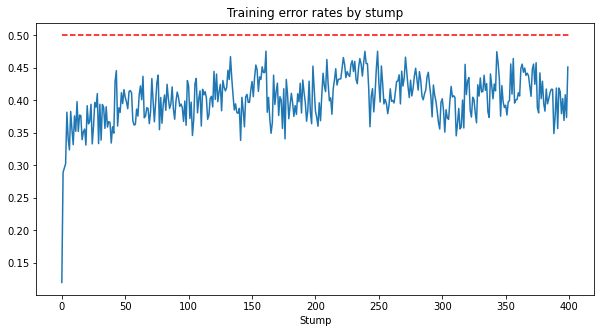

In [13]:
# Error rates during training
plt.figure(figsize=(10,5))
plt.plot(train_error)
plt.hlines(0.5, 0, 400, colors = 'red', linestyles='dashed')
plt.title('Training error rates by stump')
plt.xlabel('Stump')
plt.show()

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Out-of-sample error rates by stump')

Text(0.5, 0, 'Stump')

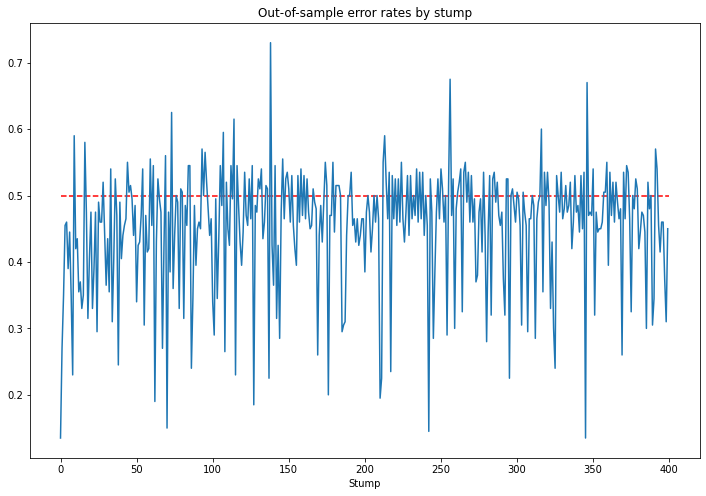

In [14]:
prediction_errors = error_rates(X_test, y_test, boost_rounds, all_clf)

# Error rates out of sample
# ab.error_rates(X_test, y_test)
plt.figure(figsize=(12,8))
plt.plot(prediction_errors)
plt.hlines(0.5, 0, 400, colors = 'red', linestyles='dashed')
plt.title('Out-of-sample error rates by stump')
plt.xlabel('Stump')
plt.show()

In [15]:
print('Error rate of metaclassifier:', round(compute_error(y_test, y_pred, np.ones(len(y_test))), 4))

Error rate of metaclassifier: 0.12


In [16]:
ab_sk = AdaBoostClassifier(n_estimators = 400) # Same boosting rounds (M) as in our model
ab_sk.fit(X_train, y_train)
y_pred_sk = ab_sk.predict(X_test)
print('The ROC-AUC score of the model is:', round(roc_auc_score(y_test, y_pred_sk), 4))

AdaBoostClassifier(n_estimators=400)

The ROC-AUC score of the model is: 0.8427


### 2) Bagging with decision trees

”Bagging” (short for ”bootstrap aggregating”) is a different method for combining decision trees or
other base classifiers. Similar to boosting, the base learning algorithm is run repeatedly in a series
of rounds. However, the manner in which the base learner is called is different than in boosting. In
particular, on each round, the base learner is trained on what is often called a ”bootstrap replicate” of
the original training set. Suppose the training set consists of m examples. Then a bootstrap replicate
is a new training set that also consists of m examples, and which is formed by repeatedly selecting
uniformly at random and with replacement m examples from the original training set. This means
that the same example may appear multiple times in the bootstrap replicate, or it may appear not at
all. Thus, on each of T rounds of bagging, a bootstrap replicate is created from the original training
set. A base classifier is then trained on this replicate, and the process continues. After T rounds,
a final combined classifier is formed which simply predicts with the majority vote of all of the base
classifiers.


In [17]:
class baggingAlgo:
  def fit(self, X_train, y_train, bootstrap_rounds, max_depth = 100, seed = None):
    self.X_train = X_train
    self.N, self.D = X_train.shape
    self.y_train = y_train
    self.bootstrap_rounds = bootstrap_rounds
    self.seed = seed
    self.trees = []
    self.train_error = []
    
    np.random.seed(seed)
    for b in range(self.bootstrap_rounds):
      sample = np.random.choice(np.arange(self.N), size = self.N, replace = True)
      X_train_b = X_train[sample]
      y_train_b = y_train[sample]
      # Using decision tree as base classifier
      tree = DecisionTreeClassifier(max_depth = max_depth)
      tree.fit(X_train_b, y_train_b)
      score = tree.score(X_train_b, y_train_b)
      self.trees.append(tree)
      self.train_error.append(score)
        
  
  def predict(self, X_test):
    y_pred = np.empty((len(self.trees), len(X_test)))
    for i, tree in enumerate(self.trees):
      y_pred[i] = tree.predict(X_test)            
        
    return self.train_error, y_pred.mean(0) 

In [18]:
def predErrorCalc(y, y_pred):
  error = (sum((np.not_equal(y, y_pred)).astype(int)))/len(y)
  return error

#### Test dataset

In [19]:
# Generate classification dataset
X, y = make_classification(n_samples= 500, n_features = 8, random_state = 42)
y = y * 2 - 1       # Original AdaBoost uses {1, -1} as class labels

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [20]:
## Build model
bagging = baggingAlgo()
bagging.fit(X_train, y_train, bootstrap_rounds = 30, max_depth = 2, seed = 123)
train_error, y_pred = bagging.predict(X_test)
y_pred = np.round(y_pred,0)

print('The ROC-AUC score of the model is:', round(roc_auc_score(y_test, y_pred), 3))
print('The accuracy score of the model is:', round(accuracy_score(y_test, y_pred), 3))

The ROC-AUC score of the model is: 0.986
The accuracy score of the model is: 0.91


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

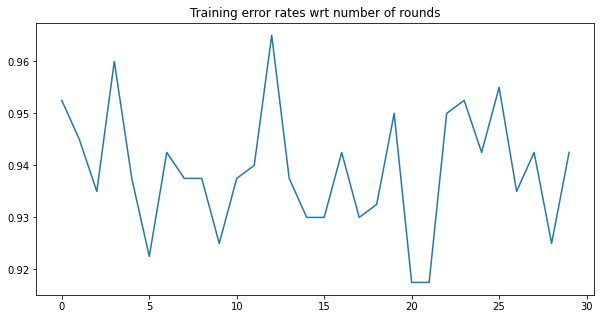

In [21]:
# Plotting Training error rates for the current round
plt.figure(figsize=(10,5))
plt.plot(train_error)
plt.title('Training error rates wrt number of rounds')
plt.show()

In [22]:
print('Error rate of final combined classifier:', round(predErrorCalc(y_test, y_pred), 4))

Error rate of final combined classifier: 0.09


### Dataset 1 - Letter dataset 

In [23]:
letter_columns = ['lettr', 'x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'mean' , 'y-bar',	'x2bar'	,'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege',	'xegvy', 'y-ege', 'yegvx']

In [24]:
# Loading data

df_letter = pd.read_csv('letter-recognition.data',names = letter_columns)
df_letter = df_letter[(df_letter['lettr'] == 'C') | (df_letter['lettr'] == 'G')]
df_letter.reset_index(inplace =  True, drop = True)
df_letter.shape
df_letter.head()

(1509, 18)

,lettr,x-box,y-box,width,high,onpix,x-bar,mean,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10,NaN
1,G,4,9,6,7,6,7,8,6,2,6,5,11,4,8,7,8,NaN
2,C,7,10,5,5,2,6,8,6,8,11,7,11,2,8,5,9,NaN
3,C,6,11,7,8,3,7,8,7,11,4,7,14,1,7,4,8,NaN
4,G,3,6,4,4,2,6,6,5,5,6,6,9,2,8,4,8,NaN


In [25]:
df_letter['lettr'].value_counts()
df_letter['lettr'] = np.where(df_letter['lettr'] == 'C', 0, 1)
df_letter['lettr'].value_counts()

G    773
C    736
Name: lettr, dtype: int64

1    773
0    736
Name: lettr, dtype: int64

In [26]:
# dropping 'yegvx' as it is empty
df_letter = df_letter.drop(columns = ['yegvx'])
df_letter.shape

(1509, 17)

In [27]:
X = df_letter.loc[:, df_letter.columns!='lettr'].to_numpy()
y = df_letter['lettr'].to_numpy()

In [28]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state = 42)

#### Experiment 1 - Boosting with Shallow trees (depth = 1)

Boosting rounds = : 1
The ROC-AUC score of the model with boosting rounds = 1 is : 0.753
The accuracy score of the model with boosting rounds = 1 is : 0.749
Error rate of final combined classifier: 0.2514


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

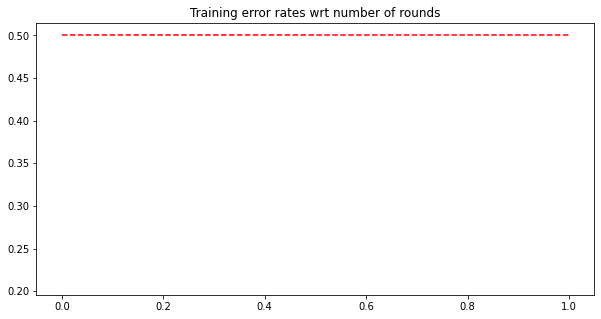

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

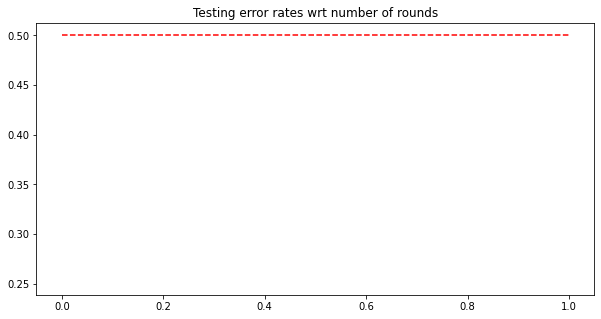

Boosting rounds = : 5
The ROC-AUC score of the model with boosting rounds = 5 is : 0.603
The accuracy score of the model with boosting rounds = 5 is : 0.594
Error rate of final combined classifier: 0.4064


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

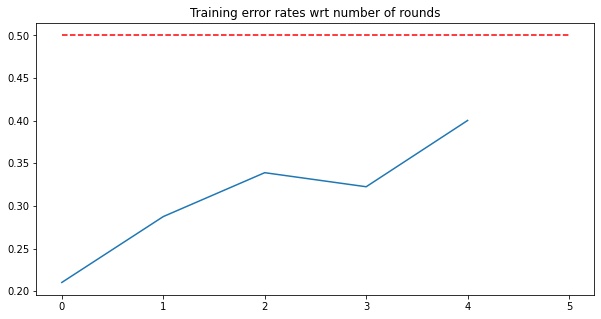

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

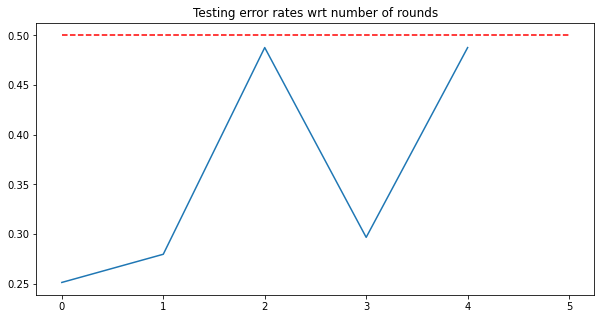

Boosting rounds = : 50
The ROC-AUC score of the model with boosting rounds = 50 is : 0.5
The accuracy score of the model with boosting rounds = 50 is : 0.488
Error rate of final combined classifier: 0.5123


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

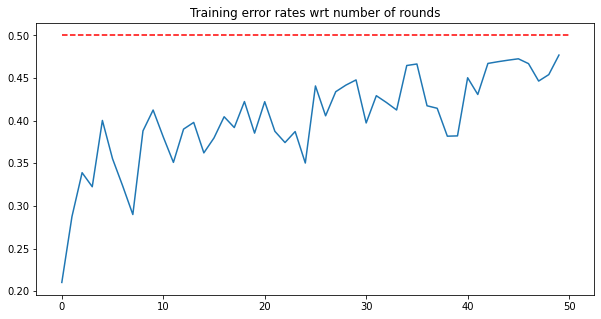

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

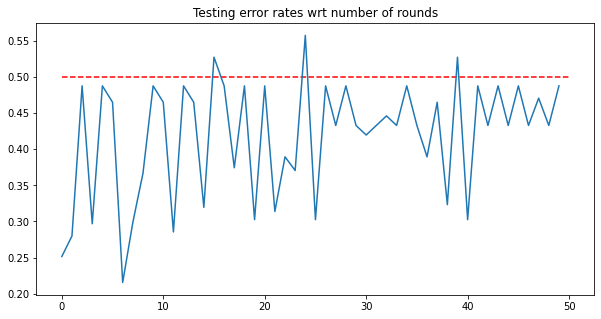

Boosting rounds = : 100
The ROC-AUC score of the model with boosting rounds = 100 is : 0.5
The accuracy score of the model with boosting rounds = 100 is : 0.488
Error rate of final combined classifier: 0.5123


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

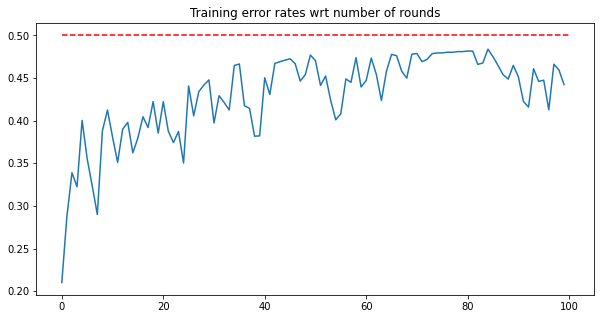

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

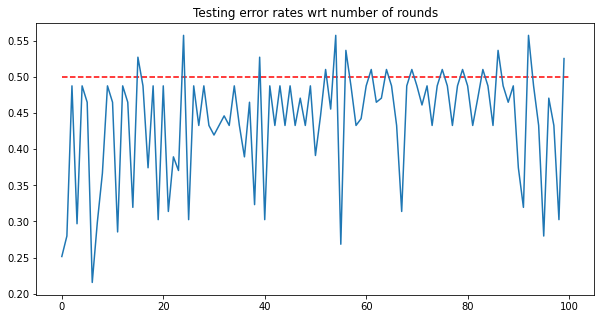

Boosting rounds = : 200
The ROC-AUC score of the model with boosting rounds = 200 is : 0.5
The accuracy score of the model with boosting rounds = 200 is : 0.488
Error rate of final combined classifier: 0.5123


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

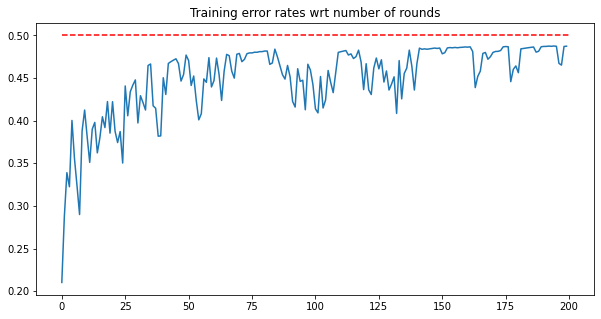

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

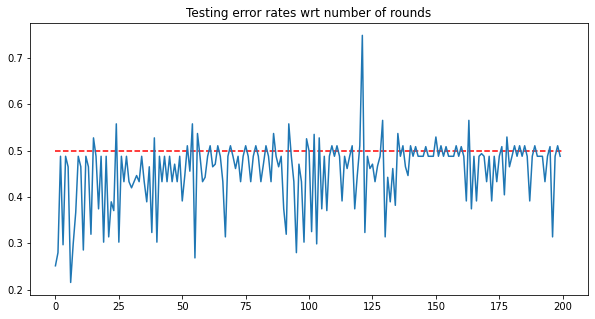

In [29]:
boost_rounds = [1, 5, 50, 100, 200]
max_depth = 1

for i in boost_rounds:
  # Fitting the model for every round value and calculating accuracy score and error rate of final classifier
  print("Boosting rounds = :", i)
  all_clf, train_error, alpha = adaBoost(X_train, y_train, i, max_depth)
  y_pred = predict(X_test, i, all_clf, alpha)
  print('The ROC-AUC score of the model with boosting rounds = {} is : {}'.format(i,round(roc_auc_score(y_test, y_pred), 3)))
  print('The accuracy score of the model with boosting rounds = {} is : {}'.format(i,round(accuracy_score(y_test, y_pred), 3)))
  print('Error rate of final combined classifier:', round(compute_error(y_test, y_pred, np.ones(len(y_test))), 4))

  # Plotting Training error rates for the current round
  plt.figure(figsize=(10,5))
  plt.plot(train_error)
  plt.hlines(0.5, 0, i, colors = 'red', linestyles='dashed')
  plt.title('Training error rates wrt number of rounds')
  plt.show()

  # Plotting Testing error rates for the current round
  plt.figure(figsize=(10,5))
  prediction_errors = error_rates(X_test, y_test, i, all_clf)
  plt.plot(prediction_errors)
  plt.hlines(0.5, 0, i, colors = 'red', linestyles='dashed')
  plt.title('Testing error rates wrt number of rounds')
  plt.show()

#### Experiment 2 - Boosting with Deep trees (depth = 7)

Boosting rounds = : 1
The ROC-AUC score of the model with boosting rounds = 1 is : 0.951
The accuracy score of the model with boosting rounds = 1 is : 0.951
Error rate of final combined classifier: 0.0491


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

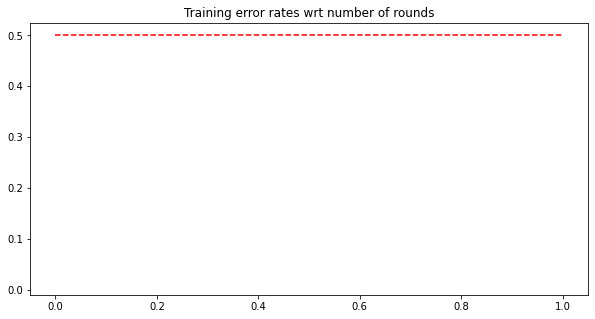

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

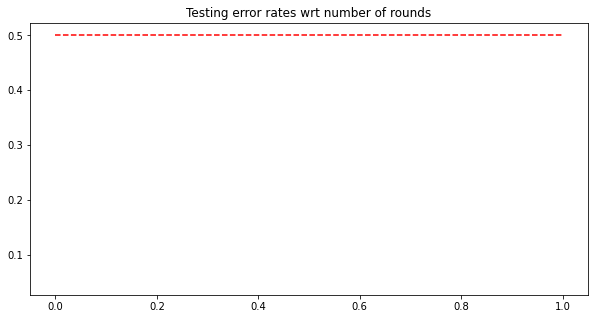

Boosting rounds = : 5
The ROC-AUC score of the model with boosting rounds = 5 is : 0.891
The accuracy score of the model with boosting rounds = 5 is : 0.888
Error rate of final combined classifier: 0.1115


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

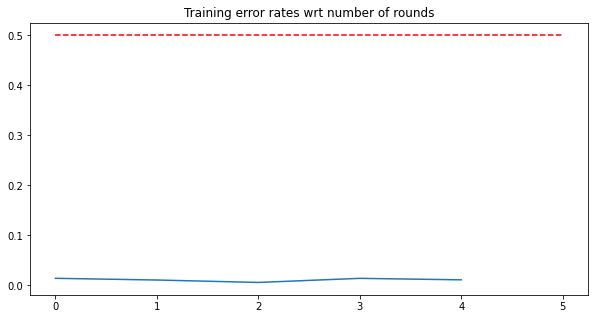

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

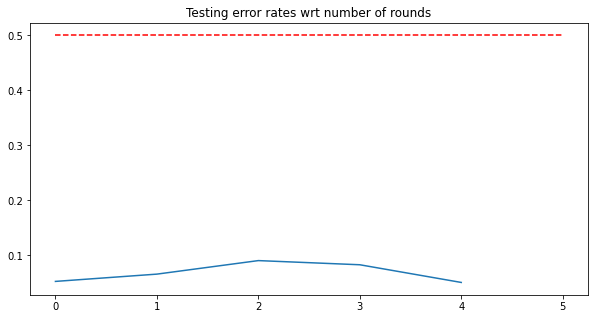

Boosting rounds = : 50
The ROC-AUC score of the model with boosting rounds = 50 is : 0.53
The accuracy score of the model with boosting rounds = 50 is : 0.518
Error rate of final combined classifier: 0.482


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

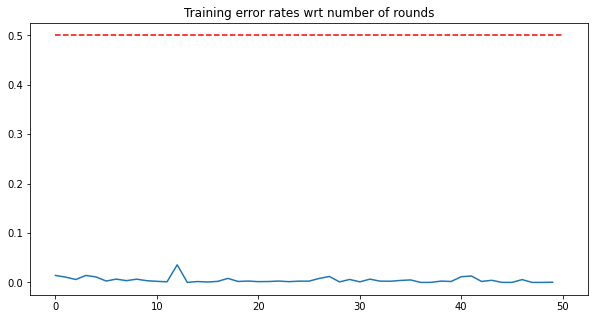

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

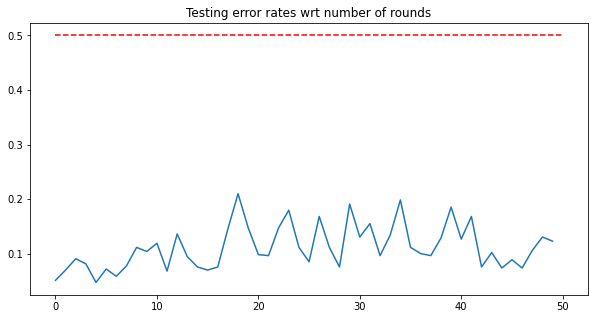

Boosting rounds = : 100
The ROC-AUC score of the model with boosting rounds = 100 is : 0.504
The accuracy score of the model with boosting rounds = 100 is : 0.491
Error rate of final combined classifier: 0.5085


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

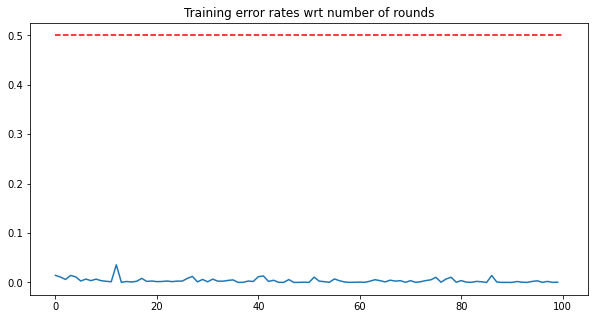

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

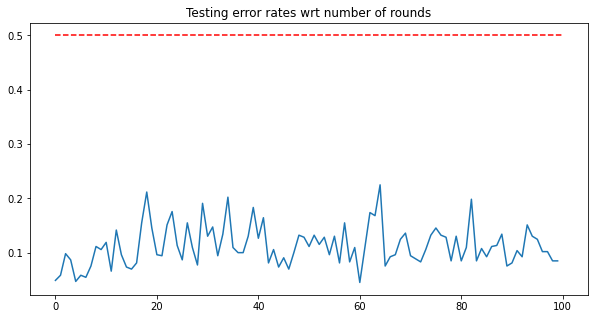

Boosting rounds = : 200
The ROC-AUC score of the model with boosting rounds = 200 is : 0.5
The accuracy score of the model with boosting rounds = 200 is : 0.488
Error rate of final combined classifier: 0.5123


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

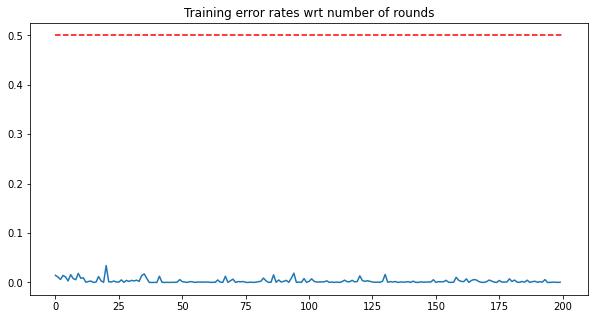

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

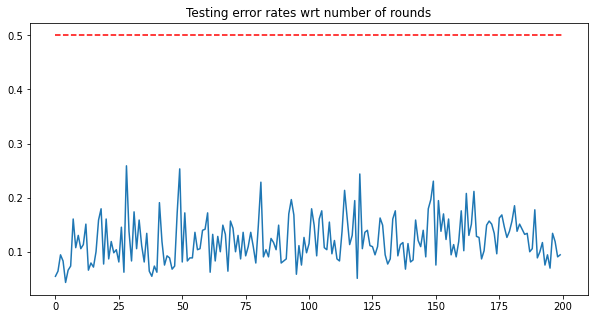

In [30]:
boost_rounds = [1, 5, 50, 100, 200]
max_depth = 7

for i in boost_rounds:
  # Fitting the model for every round value and calculating accuracy score and error rate of final classifier
  print("Boosting rounds = :", i)
  all_clf, train_error, alpha = adaBoost(X_train, y_train, i, max_depth)
  y_pred = predict(X_test, i, all_clf, alpha)
  print('The ROC-AUC score of the model with boosting rounds = {} is : {}'.format(i,round(roc_auc_score(y_test, y_pred), 3)))
  print('The accuracy score of the model with boosting rounds = {} is : {}'.format(i,round(accuracy_score(y_test, y_pred), 3)))
  print('Error rate of final combined classifier:', round(compute_error(y_test, y_pred, np.ones(len(y_test))), 4))

  # Plotting Training error rates for the current round
  plt.figure(figsize=(10,5))
  plt.plot(train_error)
  plt.hlines(0.5, 0, i, colors = 'red', linestyles='dashed')
  plt.title('Training error rates wrt number of rounds')
  plt.show()

  # Plotting Testing error rates for the current round
  plt.figure(figsize=(10,5))
  prediction_errors = error_rates(X_test, y_test, i, all_clf)
  plt.plot(prediction_errors)
  plt.hlines(0.5, 0, i, colors = 'red', linestyles='dashed')
  plt.title('Testing error rates wrt number of rounds')
  plt.show()

#### Experiment 3 - Bagging with Shallow trees (depth = 1)

Bagging rounds = : 1
The ROC-AUC score of the model with bootstrap rounds = 1 is : 0.842
The accuracy score of the model with boosting rounds = 1 is : 0.839


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

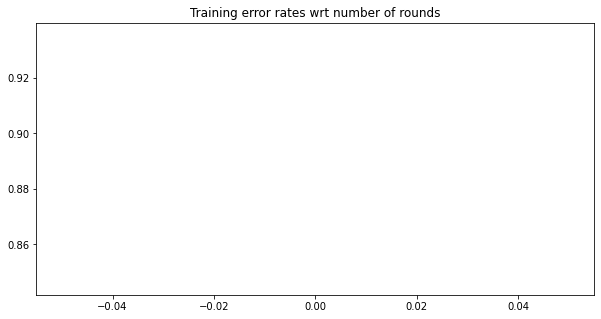

Bagging rounds = : 5
The ROC-AUC score of the model with bootstrap rounds = 5 is : 0.842
The accuracy score of the model with boosting rounds = 5 is : 0.839


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

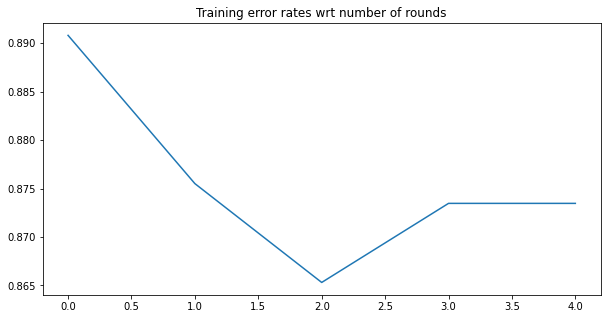

Bagging rounds = : 50
The ROC-AUC score of the model with bootstrap rounds = 50 is : 0.842
The accuracy score of the model with boosting rounds = 50 is : 0.839


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

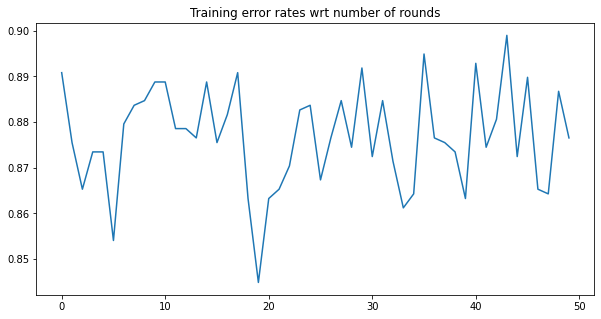

Bagging rounds = : 100
The ROC-AUC score of the model with bootstrap rounds = 100 is : 0.842
The accuracy score of the model with boosting rounds = 100 is : 0.839


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

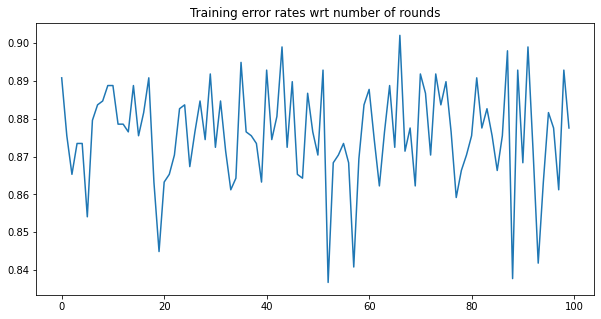

Bagging rounds = : 200
The ROC-AUC score of the model with bootstrap rounds = 200 is : 0.842
The accuracy score of the model with boosting rounds = 200 is : 0.839


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

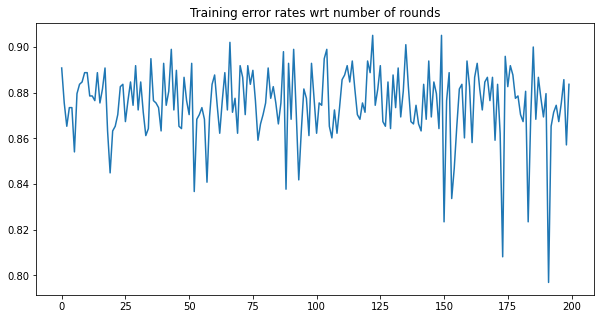

In [31]:
bootstrap_rounds = [1, 5, 50, 100, 200]
max_depth = 1
test_error_total = []

for i in bootstrap_rounds:
    
  # Fitting the model for every round value and calculating accuracy score and error rate of final classifier
  print("Bagging rounds = :", i)
  bagger = baggingAlgo()
  bagger.fit(X_train, y_train, i, max_depth = 2, seed = 123)
  train_error, y_test_hat = bagger.predict(X_test)
  y_test_hat = np.round(y_test_hat,0)
  test_error = predErrorCalc(y_test, y_test_hat)
  print('The ROC-AUC score of the model with bootstrap rounds = {} is : {}'.format(i,round(roc_auc_score(y_test, y_test_hat), 3)))
  print('The accuracy score of the model with boosting rounds = {} is : {}'.format(i,round(accuracy_score(y_test, y_test_hat), 3)))

  # Plotting Training error rates for the current round
  plt.figure(figsize=(10,5))
  plt.plot(train_error)
  plt.title('Training error rates wrt number of rounds')
  plt.show()

  test_error_total.append(test_error)

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

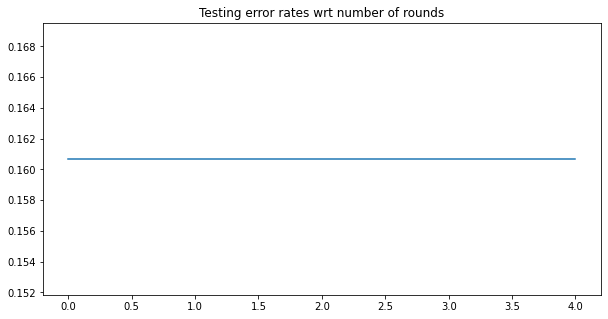

In [32]:
# Plotting Testing error rates for the current round
plt.figure(figsize=(10,5))
# prediction_errors = error_rates(X_test, y_test, i, all_clf)
plt.plot(test_error_total)
# plt.hlines(0.5, 0, boost_rounds, colors = 'red', linestyles='dashed')
plt.title('Testing error rates wrt number of rounds')
plt.show()

#### Experiment 4 - Bagging with Deep trees (depth = 15)

Bagging rounds = : 1
The ROC-AUC score of the model with bootstrap rounds = 1 is : 0.842
The accuracy score of the model with boosting rounds = 1 is : 0.839


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

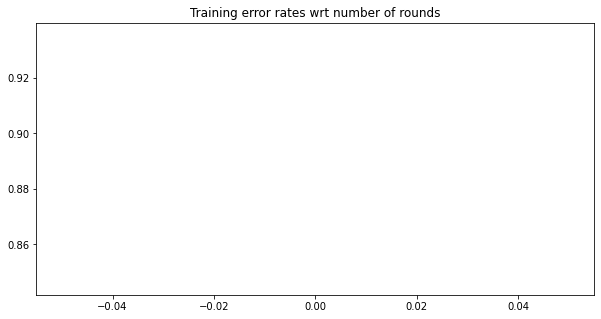

Bagging rounds = : 5
The ROC-AUC score of the model with bootstrap rounds = 5 is : 0.842
The accuracy score of the model with boosting rounds = 5 is : 0.839


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

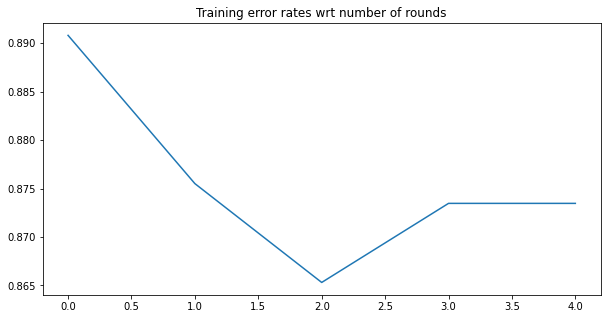

Bagging rounds = : 50
The ROC-AUC score of the model with bootstrap rounds = 50 is : 0.842
The accuracy score of the model with boosting rounds = 50 is : 0.839


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

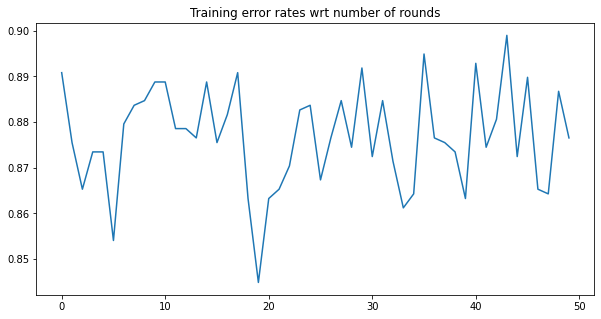

Bagging rounds = : 100
The ROC-AUC score of the model with bootstrap rounds = 100 is : 0.842
The accuracy score of the model with boosting rounds = 100 is : 0.839


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

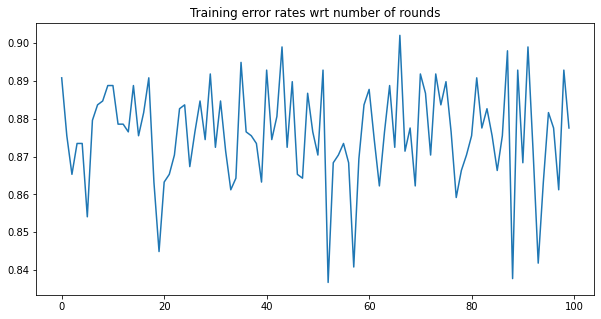

Bagging rounds = : 200
The ROC-AUC score of the model with bootstrap rounds = 200 is : 0.842
The accuracy score of the model with boosting rounds = 200 is : 0.839


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

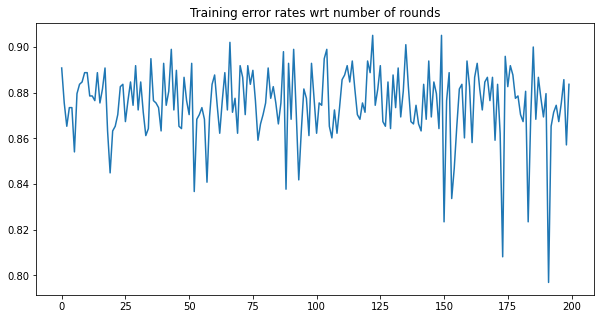

In [33]:
bootstrap_rounds = [1, 5, 50, 100, 200]
max_depth = 15
test_error_total = []

for i in bootstrap_rounds:
    
  # Fitting the model for every round value and calculating accuracy score and error rate of final classifier
  print("Bagging rounds = :", i)
  bagger = baggingAlgo()
  bagger.fit(X_train, y_train, i, max_depth = 2, seed = 123)
  train_error, y_test_hat = bagger.predict(X_test)
  y_test_hat = np.round(y_test_hat,0)
  test_error = predErrorCalc(y_test, y_test_hat)
  print('The ROC-AUC score of the model with bootstrap rounds = {} is : {}'.format(i,round(roc_auc_score(y_test, y_test_hat), 3)))
  print('The accuracy score of the model with boosting rounds = {} is : {}'.format(i,round(accuracy_score(y_test, y_test_hat), 3)))

  # Plotting Training error rates for the current round
  plt.figure(figsize=(10,5))
  plt.plot(train_error)
  plt.title('Training error rates wrt number of rounds')
  plt.show()

  test_error_total.append(test_error)

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

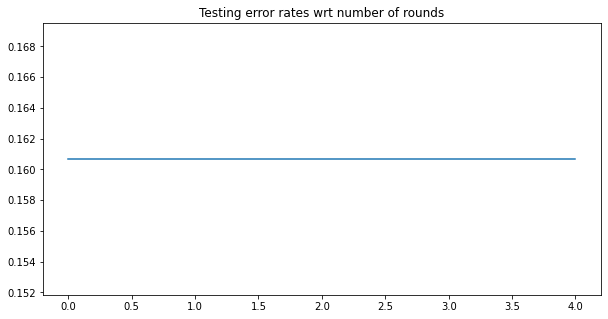

In [34]:
# Plotting Testing error rates for the current round
plt.figure(figsize=(10,5))
# prediction_errors = error_rates(X_test, y_test, i, all_clf)
plt.plot(test_error_total)
# plt.hlines(0.5, 0, boost_rounds, colors = 'red', linestyles='dashed')
plt.title('Testing error rates wrt number of rounds')
plt.show()

#### Decision tree

In [35]:
clf = DecisionTreeClassifier()
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# print("Score:", clf.score(y_test, y_pred))
print("Depth :", clf.get_depth())

Accuracy: 0.9357277882797732
Depth : 14


### Dataset 2 - Credit dataset

In [36]:
# Loading data

df_credit = pd.read_csv('german.data',sep = "\s+", header = None)
df_credit.shape
df_credit.head()

(1000, 21)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


In [37]:
df_credit[20].value_counts()

1    700
2    300
Name: 20, dtype: int64

In [38]:
# Creating a list of categorical columns
df_credit.dtypes

cols = df_credit.columns
num_cols = df_credit._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

0     object
1      int64
2     object
3     object
4      int64
5     object
6     object
7      int64
8     object
9     object
10     int64
11    object
12     int64
13    object
14    object
15     int64
16    object
17     int64
18    object
19    object
20     int64
dtype: object

[0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19]

In [39]:
# Label encoding all categorical columns

for var in cat_cols:
    lb = LabelEncoder()
    temp = lb.fit_transform(df_credit[var])
    df_credit[var] = lb.transform(np.array(df_credit[var]).astype('str'))

df_credit.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0,6,4,4,1169,4,4,4,2,0,4,0,67,2,1,2,2,1,1,0,1
1,1,48,2,4,5951,0,2,2,1,0,2,0,22,2,1,1,2,1,0,0,2
2,3,12,4,7,2096,0,3,2,2,0,3,0,49,2,1,1,1,2,0,0,1


In [40]:
X = df_credit.loc[:, df_credit.columns!= 20].to_numpy()
y = df_credit[20].to_numpy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state = 42)

#### Experiment 5 - Boosting with Shallow trees (depth = 1)


Boosting rounds = : 1
The ROC-AUC score of the model with boosting rounds = 1 is : 0.5
The accuracy score of the model with boosting rounds = 1 is : 0.7
Error rate of final combined classifier: 0.3


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

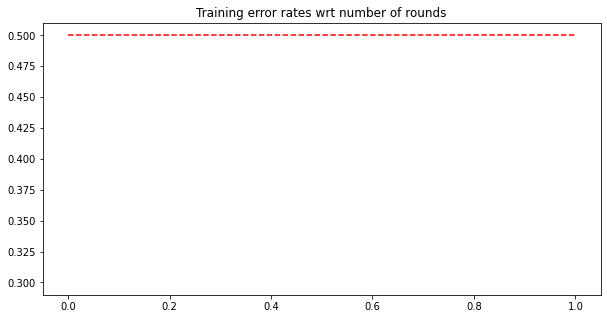

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

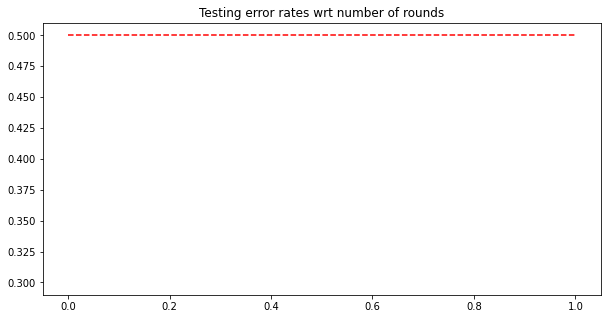

Boosting rounds = : 5
The ROC-AUC score of the model with boosting rounds = 5 is : 0.5
The accuracy score of the model with boosting rounds = 5 is : 0.7
Error rate of final combined classifier: 0.3


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

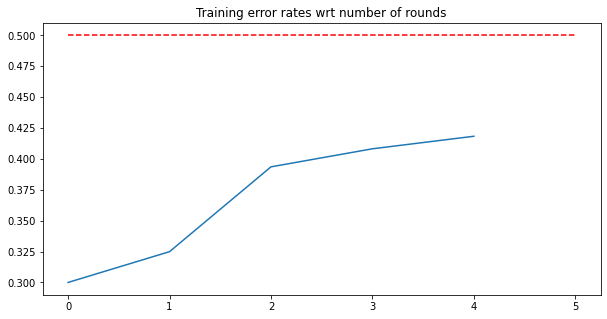

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

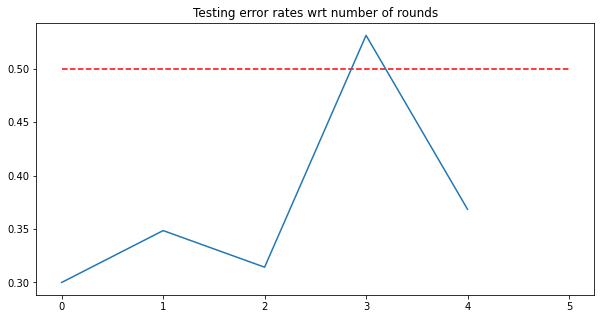

Boosting rounds = : 50
The ROC-AUC score of the model with boosting rounds = 50 is : 0.5
The accuracy score of the model with boosting rounds = 50 is : 0.7
Error rate of final combined classifier: 0.3


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

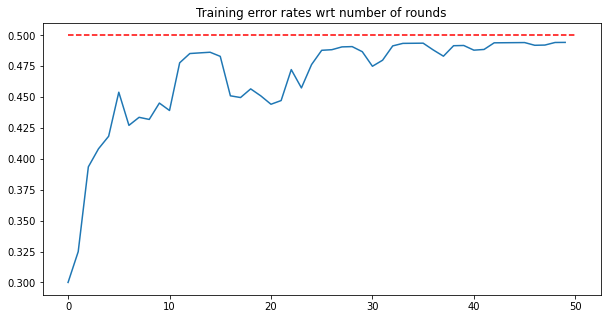

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

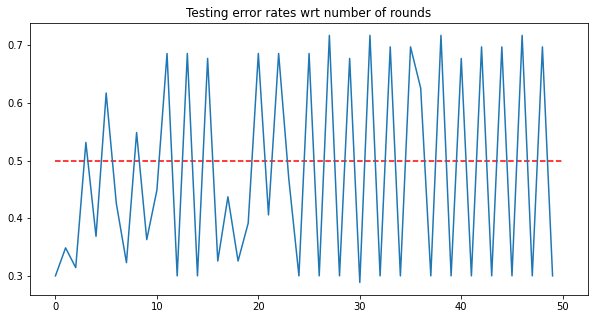

Boosting rounds = : 100
The ROC-AUC score of the model with boosting rounds = 100 is : 0.5
The accuracy score of the model with boosting rounds = 100 is : 0.7
Error rate of final combined classifier: 0.3


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

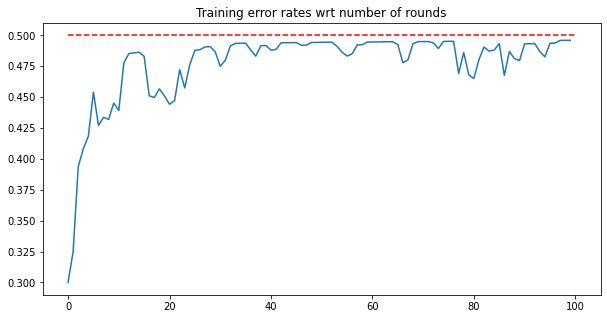

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

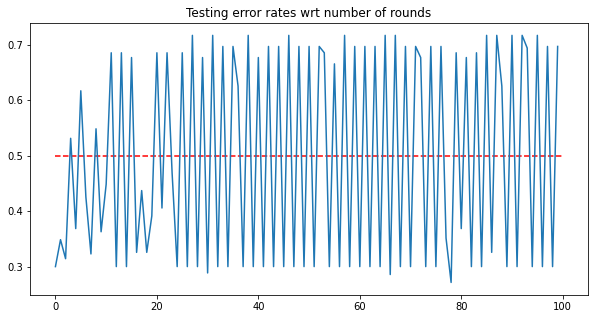

Boosting rounds = : 200
The ROC-AUC score of the model with boosting rounds = 200 is : 0.5
The accuracy score of the model with boosting rounds = 200 is : 0.7
Error rate of final combined classifier: 0.3


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

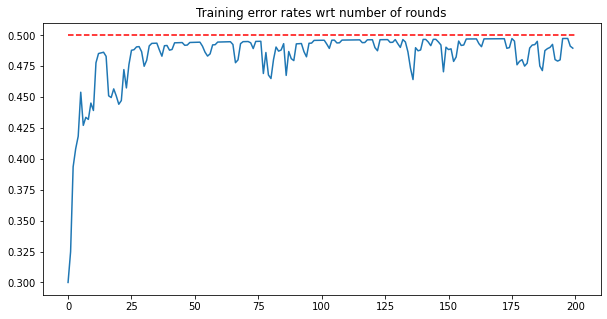

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

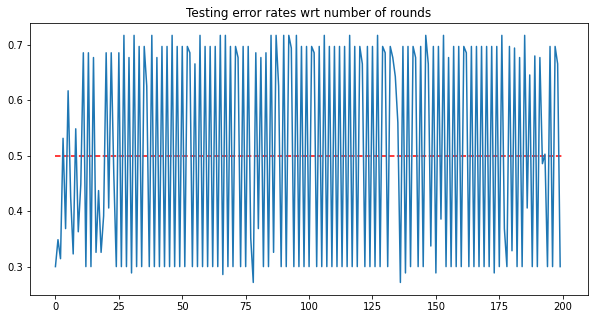

In [41]:
boost_rounds = [1, 5, 50, 100, 200]
max_depth = 1

for i in boost_rounds:
  # Fitting the model for every round value and calculating accuracy score and error rate of final classifier
  print("Boosting rounds = :", i)
  all_clf, train_error, alpha = adaBoost(X_train, y_train, i, max_depth)
  y_pred = predict(X_test, i, all_clf, alpha)
  print('The ROC-AUC score of the model with boosting rounds = {} is : {}'.format(i,round(roc_auc_score(y_test, y_pred), 3)))
  print('The accuracy score of the model with boosting rounds = {} is : {}'.format(i,round(accuracy_score(y_test, y_pred), 3)))
  print('Error rate of final combined classifier:', round(compute_error(y_test, y_pred, np.ones(len(y_test))), 4))

  # Plotting Training error rates for the current round
  plt.figure(figsize=(10,5))
  plt.plot(train_error)
  plt.hlines(0.5, 0, i, colors = 'red', linestyles='dashed')
  plt.title('Training error rates wrt number of rounds')
  plt.show()

  # Plotting Testing error rates for the current round
  plt.figure(figsize=(10,5))
  prediction_errors = error_rates(X_test, y_test, i, all_clf)
  plt.plot(prediction_errors)
  plt.hlines(0.5, 0, i, colors = 'red', linestyles='dashed')
  plt.title('Testing error rates wrt number of rounds')
  plt.show()

#### Experiment 6 - Boosting with Deep trees (depth = 8)

Boosting rounds = : 1
The ROC-AUC score of the model with boosting rounds = 1 is : 0.5
The accuracy score of the model with boosting rounds = 1 is : 0.7
Error rate of final combined classifier: 0.3


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

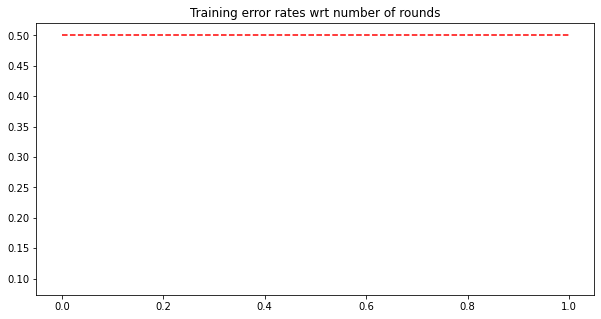

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

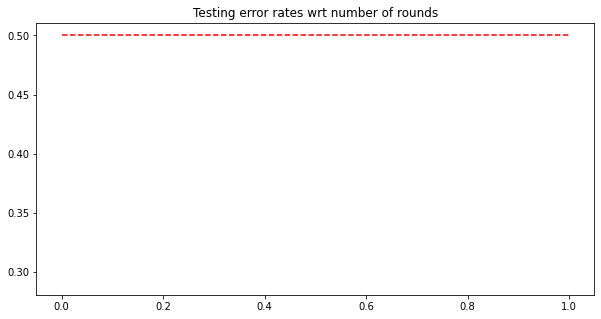

Boosting rounds = : 5
The ROC-AUC score of the model with boosting rounds = 5 is : 0.5
The accuracy score of the model with boosting rounds = 5 is : 0.7
Error rate of final combined classifier: 0.3


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

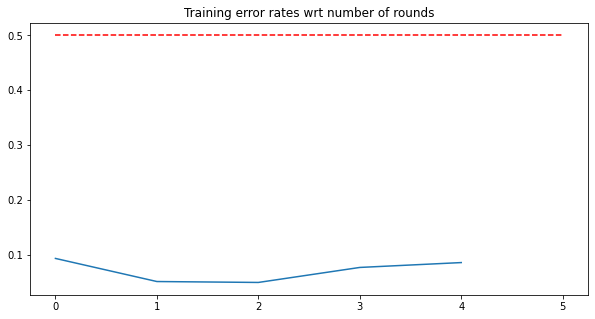

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

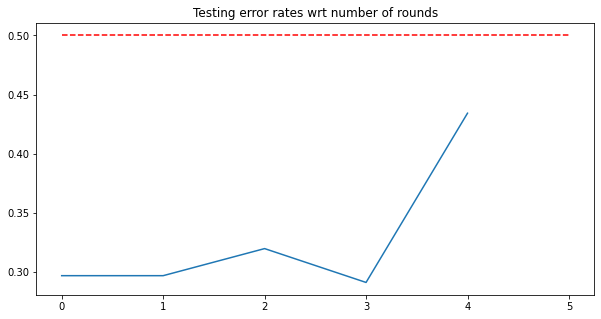

Boosting rounds = : 50
The ROC-AUC score of the model with boosting rounds = 50 is : 0.5
The accuracy score of the model with boosting rounds = 50 is : 0.7
Error rate of final combined classifier: 0.3


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

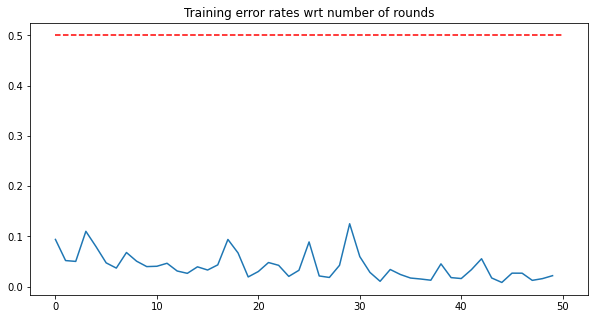

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

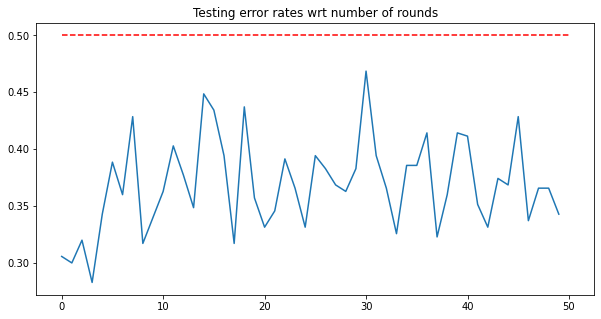

Boosting rounds = : 100
The ROC-AUC score of the model with boosting rounds = 100 is : 0.5
The accuracy score of the model with boosting rounds = 100 is : 0.7
Error rate of final combined classifier: 0.3


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

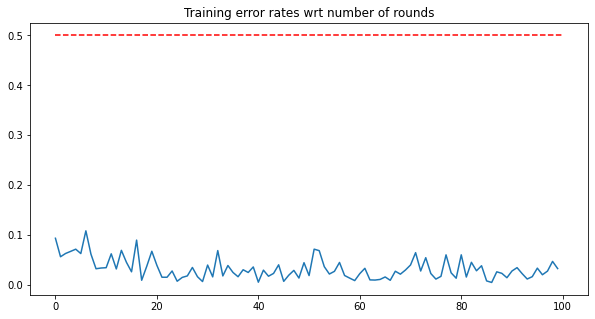

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

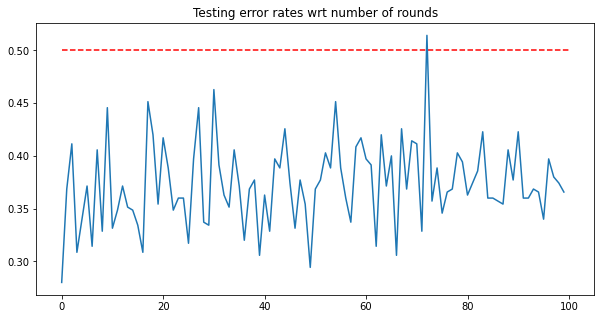

Boosting rounds = : 200
The ROC-AUC score of the model with boosting rounds = 200 is : 0.5
The accuracy score of the model with boosting rounds = 200 is : 0.7
Error rate of final combined classifier: 0.3


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

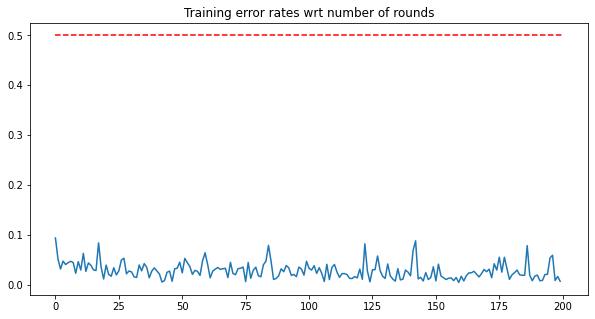

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

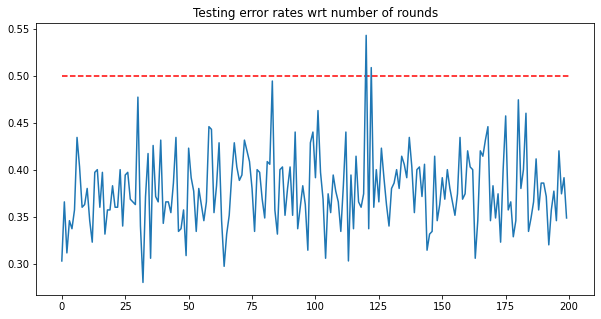

In [42]:
boost_rounds = [1, 5, 50, 100, 200]
max_depth = 8

for i in boost_rounds:
  # Fitting the model for every round value and calculating accuracy score and error rate of final classifier
  print("Boosting rounds = :", i)
  all_clf, train_error, alpha = adaBoost(X_train, y_train, i, max_depth)
  y_pred = predict(X_test, i, all_clf, alpha)
  print('The ROC-AUC score of the model with boosting rounds = {} is : {}'.format(i,round(roc_auc_score(y_test, y_pred), 3)))
  print('The accuracy score of the model with boosting rounds = {} is : {}'.format(i,round(accuracy_score(y_test, y_pred), 3)))
  print('Error rate of final combined classifier:', round(compute_error(y_test, y_pred, np.ones(len(y_test))), 4))

  # Plotting Training error rates for the current round
  plt.figure(figsize=(10,5))
  plt.plot(train_error)
  plt.hlines(0.5, 0, i, colors = 'red', linestyles='dashed')
  plt.title('Training error rates wrt number of rounds')
  plt.show()

  # Plotting Testing error rates for the current round
  plt.figure(figsize=(10,5))
  prediction_errors = error_rates(X_test, y_test, i, all_clf)
  plt.plot(prediction_errors)
  plt.hlines(0.5, 0, i, colors = 'red', linestyles='dashed')
  plt.title('Testing error rates wrt number of rounds')
  plt.show()

#### Experiment 7 - Bagging with Shallow trees (depth = 1)


Bagging rounds = : 1
The ROC-AUC score of the model with bootstrap rounds = 1 is : 0.665
The accuracy score of the model with boosting rounds = 1 is : 0.691


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

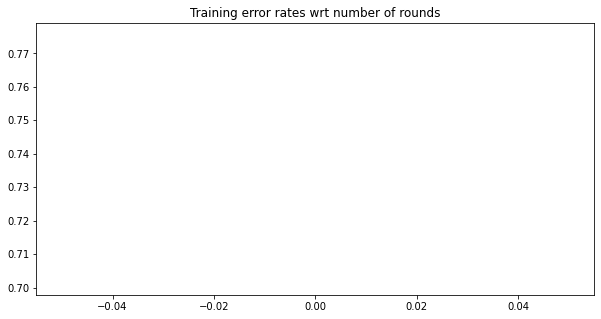

Bagging rounds = : 5
The ROC-AUC score of the model with bootstrap rounds = 5 is : 0.618
The accuracy score of the model with boosting rounds = 5 is : 0.697


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

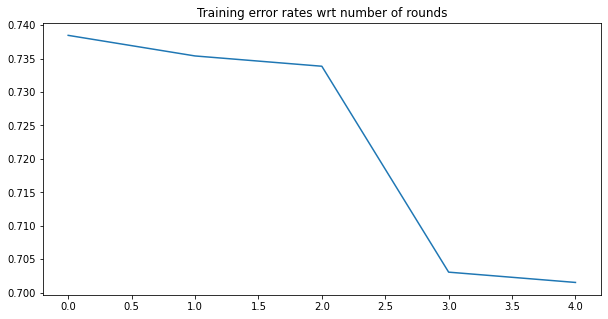

Bagging rounds = : 50
The ROC-AUC score of the model with bootstrap rounds = 50 is : 0.641
The accuracy score of the model with boosting rounds = 50 is : 0.737


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

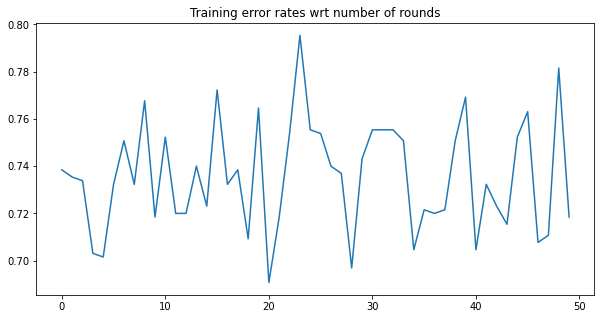

Bagging rounds = : 100
The ROC-AUC score of the model with bootstrap rounds = 100 is : 0.629
The accuracy score of the model with boosting rounds = 100 is : 0.731


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

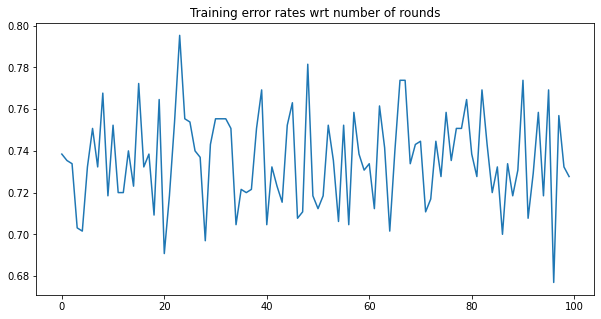

Bagging rounds = : 200
The ROC-AUC score of the model with bootstrap rounds = 200 is : 0.612
The accuracy score of the model with boosting rounds = 200 is : 0.723


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

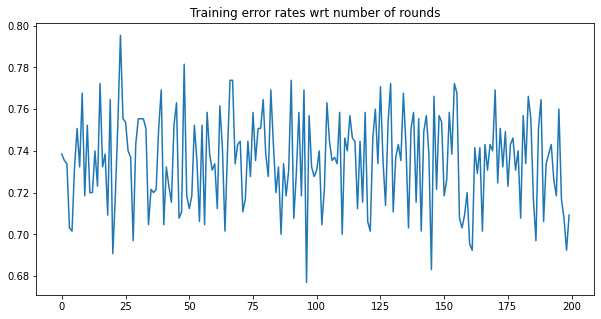

In [43]:
bootstrap_rounds = [1, 5, 50, 100, 200]
max_depth = 1
test_error_total = []

for i in bootstrap_rounds:
    
  # Fitting the model for every round value and calculating accuracy score and error rate of final classifier
  print("Bagging rounds = :", i)
  bagger = baggingAlgo()
  bagger.fit(X_train, y_train, i, max_depth = 2, seed = 123)
  train_error, y_test_hat = bagger.predict(X_test)
  y_test_hat = np.round(y_test_hat,0)
  test_error = predErrorCalc(y_test, y_test_hat)
  print('The ROC-AUC score of the model with bootstrap rounds = {} is : {}'.format(i,round(roc_auc_score(y_test, y_test_hat), 3)))
  print('The accuracy score of the model with boosting rounds = {} is : {}'.format(i,round(accuracy_score(y_test, y_test_hat), 3)))

  # Plotting Training error rates for the current round
  plt.figure(figsize=(10,5))
  plt.plot(train_error)
  plt.title('Training error rates wrt number of rounds')
  plt.show()

  test_error_total.append(test_error)

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

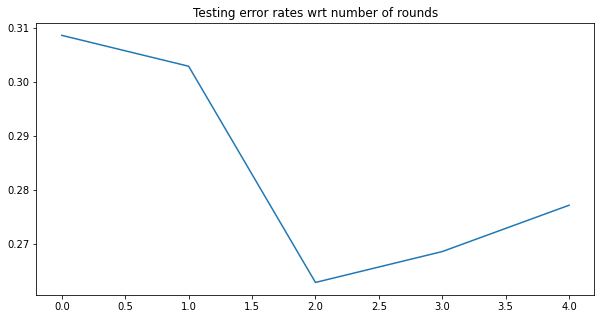

In [44]:
# Plotting Testing error rates for the current round
plt.figure(figsize=(10,5))
# prediction_errors = error_rates(X_test, y_test, i, all_clf)
plt.plot(test_error_total)
# plt.hlines(0.5, 0, boost_rounds, colors = 'red', linestyles='dashed')
plt.title('Testing error rates wrt number of rounds')
plt.show()

#### Experiment 8 - Bagging with Deep trees (depth = 18)

Bagging rounds = : 1
The ROC-AUC score of the model with bootstrap rounds = 1 is : 0.665
The accuracy score of the model with boosting rounds = 1 is : 0.691


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

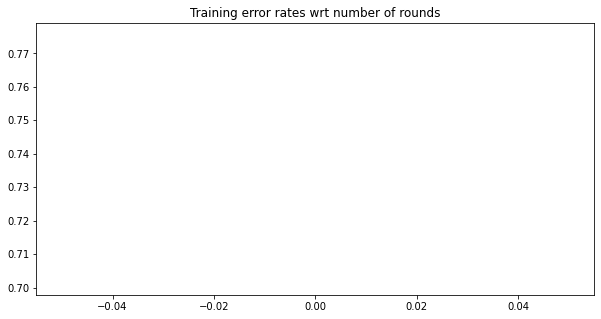

Bagging rounds = : 5
The ROC-AUC score of the model with bootstrap rounds = 5 is : 0.618
The accuracy score of the model with boosting rounds = 5 is : 0.697


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

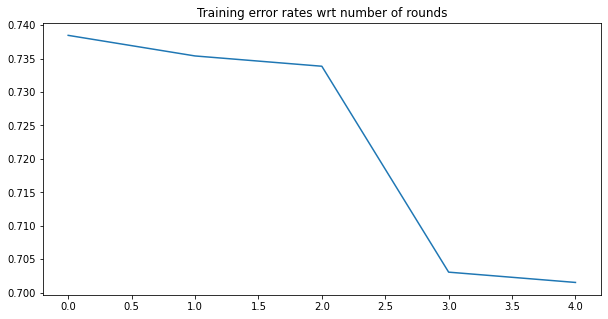

Bagging rounds = : 50
The ROC-AUC score of the model with bootstrap rounds = 50 is : 0.641
The accuracy score of the model with boosting rounds = 50 is : 0.737


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

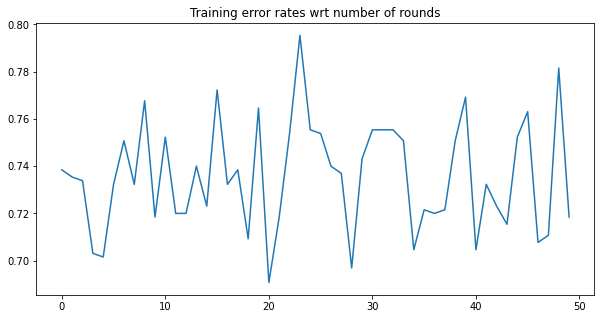

Bagging rounds = : 100
The ROC-AUC score of the model with bootstrap rounds = 100 is : 0.629
The accuracy score of the model with boosting rounds = 100 is : 0.731


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

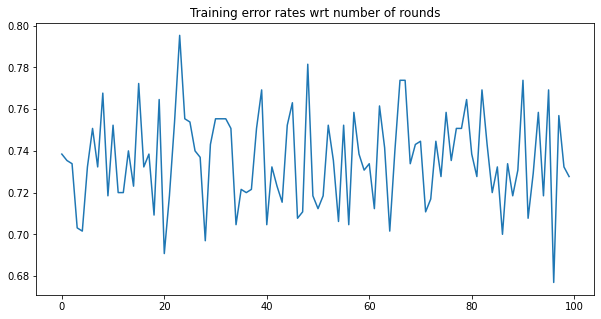

Bagging rounds = : 200
The ROC-AUC score of the model with bootstrap rounds = 200 is : 0.612
The accuracy score of the model with boosting rounds = 200 is : 0.723


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

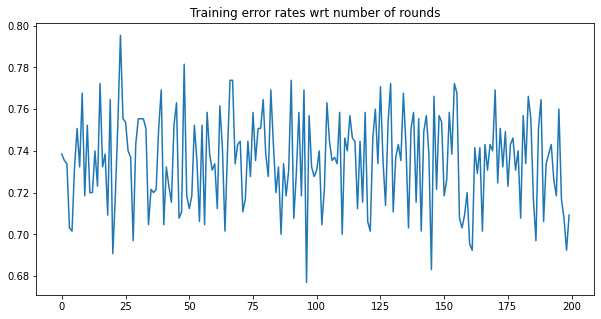

In [45]:
bootstrap_rounds = [1, 5, 50, 100, 200]
max_depth = 15
test_error_total = []

for i in bootstrap_rounds:
    
  # Fitting the model for every round value and calculating accuracy score and error rate of final classifier
  print("Bagging rounds = :", i)
  bagger = baggingAlgo()
  bagger.fit(X_train, y_train, i, max_depth = 2, seed = 123)
  train_error, y_test_hat = bagger.predict(X_test)
  y_test_hat = np.round(y_test_hat,0)
  test_error = predErrorCalc(y_test, y_test_hat)
  print('The ROC-AUC score of the model with bootstrap rounds = {} is : {}'.format(i,round(roc_auc_score(y_test, y_test_hat), 3)))
  print('The accuracy score of the model with boosting rounds = {} is : {}'.format(i,round(accuracy_score(y_test, y_test_hat), 3)))

  # Plotting Training error rates for the current round
  plt.figure(figsize=(10,5))
  plt.plot(train_error)
  plt.title('Training error rates wrt number of rounds')
  plt.show()

  test_error_total.append(test_error)

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

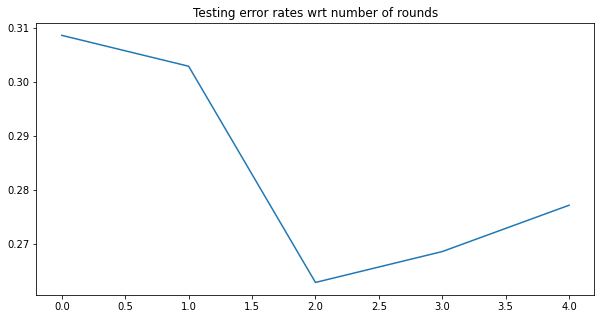

In [46]:
# Plotting Testing error rates for the current round
plt.figure(figsize=(10,5))
# prediction_errors = error_rates(X_test, y_test, i, all_clf)
plt.plot(test_error_total)
# plt.hlines(0.5, 0, boost_rounds, colors = 'red', linestyles='dashed')
plt.title('Testing error rates wrt number of rounds')
plt.show()

#### Decision tree

In [47]:
clf = DecisionTreeClassifier()
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# print("Score:", clf.score(y_test, y_pred))
print("Depth :", clf.get_depth())

Accuracy: 0.7085714285714285
Depth : 18


### Dataset 3 - Spam dataset

In [48]:
# Loading data

df_spam = pd.read_csv('spambase.data',header = None)
df_spam.shape
df_spam.head()

(4601, 58)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [49]:
df_spam[57].value_counts()

0    2788
1    1813
Name: 57, dtype: int64

In [50]:
X = df_spam.loc[:, df_spam.columns!= 57].to_numpy()
y = df_spam[57].to_numpy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state = 42)

#### Experiment 9 - Boosting with Shallow trees (depth = 1)


Boosting rounds = : 1
The ROC-AUC score of the model with boosting rounds = 1 is : 0.749
The accuracy score of the model with boosting rounds = 1 is : 0.783
Error rate of final combined classifier: 0.2166


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

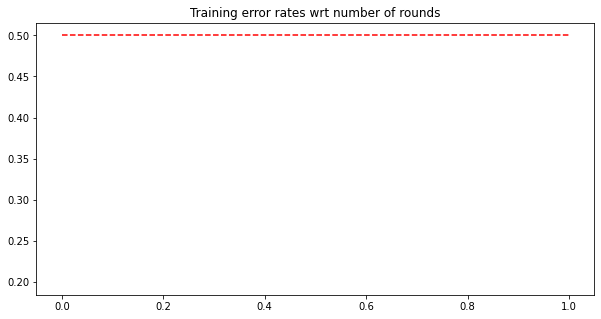

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

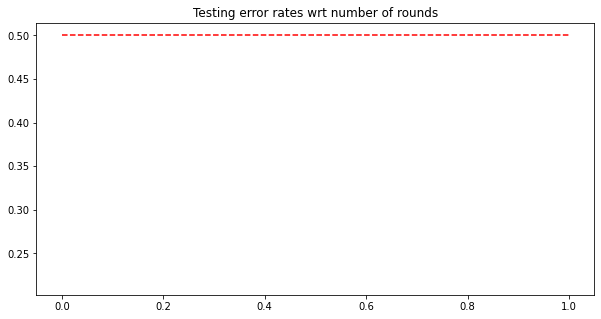

Boosting rounds = : 5
The ROC-AUC score of the model with boosting rounds = 5 is : 0.547
The accuracy score of the model with boosting rounds = 5 is : 0.467
Error rate of final combined classifier: 0.5326


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

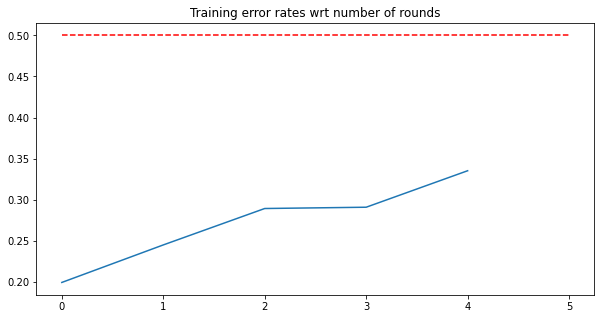

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

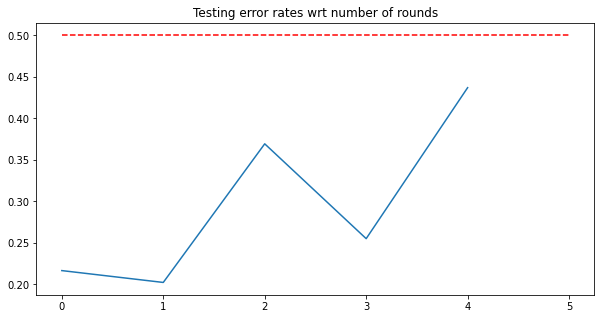

Boosting rounds = : 50
The ROC-AUC score of the model with boosting rounds = 50 is : 0.5
The accuracy score of the model with boosting rounds = 50 is : 0.412
Error rate of final combined classifier: 0.5885


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

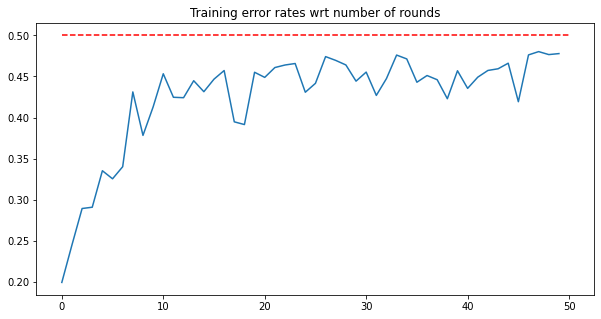

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

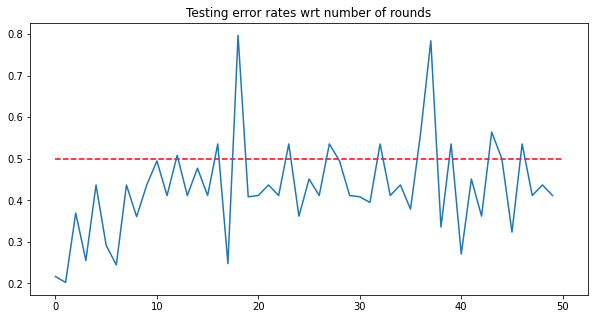

Boosting rounds = : 100
The ROC-AUC score of the model with boosting rounds = 100 is : 0.5
The accuracy score of the model with boosting rounds = 100 is : 0.412
Error rate of final combined classifier: 0.5885


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

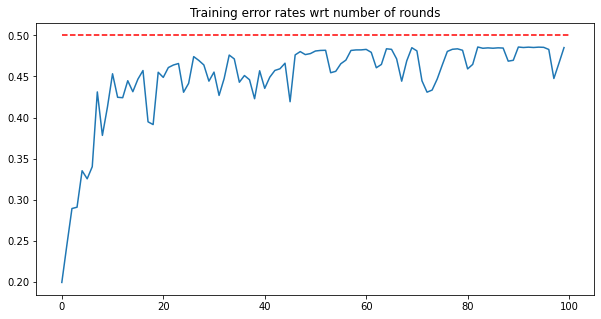

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

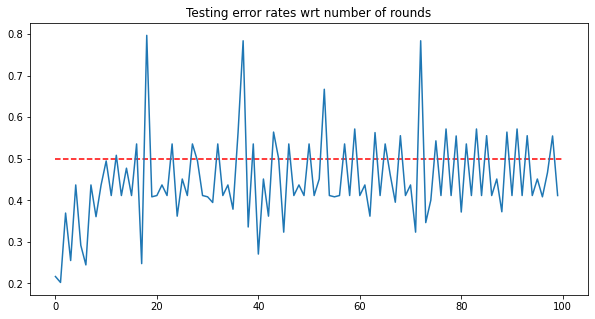

Boosting rounds = : 200
The ROC-AUC score of the model with boosting rounds = 200 is : 0.5
The accuracy score of the model with boosting rounds = 200 is : 0.412
Error rate of final combined classifier: 0.5885


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

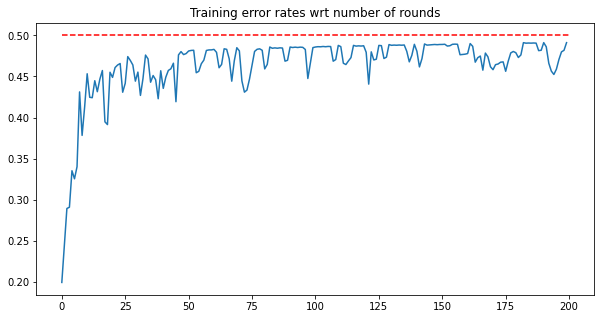

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

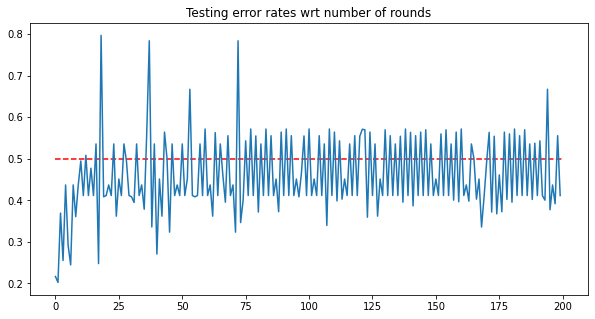

In [51]:
boost_rounds = [1, 5, 50, 100, 200]
max_depth = 1

for i in boost_rounds:
  # Fitting the model for every round value and calculating accuracy score and error rate of final classifier
  print("Boosting rounds = :", i)
  all_clf, train_error, alpha = adaBoost(X_train, y_train, i, max_depth)
  y_pred = predict(X_test, i, all_clf, alpha)
  print('The ROC-AUC score of the model with boosting rounds = {} is : {}'.format(i,round(roc_auc_score(y_test, y_pred), 3)))
  print('The accuracy score of the model with boosting rounds = {} is : {}'.format(i,round(accuracy_score(y_test, y_pred), 3)))
  print('Error rate of final combined classifier:', round(compute_error(y_test, y_pred, np.ones(len(y_test))), 4))

  # Plotting Training error rates for the current round
  plt.figure(figsize=(10,5))
  plt.plot(train_error)
  plt.hlines(0.5, 0, i, colors = 'red', linestyles='dashed')
  plt.title('Training error rates wrt number of rounds')
  plt.show()

  # Plotting Testing error rates for the current round
  plt.figure(figsize=(10,5))
  prediction_errors = error_rates(X_test, y_test, i, all_clf)
  plt.plot(prediction_errors)
  plt.hlines(0.5, 0, i, colors = 'red', linestyles='dashed')
  plt.title('Testing error rates wrt number of rounds')
  plt.show()

#### Experiment 10 - Boosting with Deep trees (depth = 20)

Boosting rounds = : 1
The ROC-AUC score of the model with boosting rounds = 1 is : 0.905
The accuracy score of the model with boosting rounds = 1 is : 0.91
Error rate of final combined classifier: 0.09


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

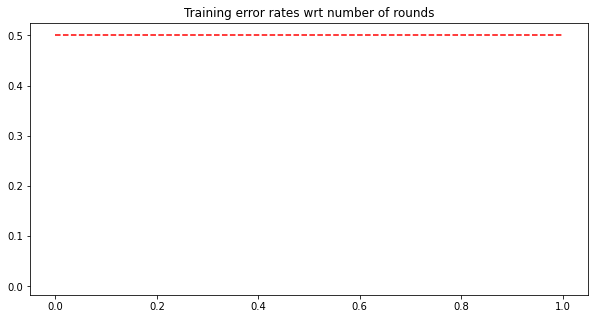

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

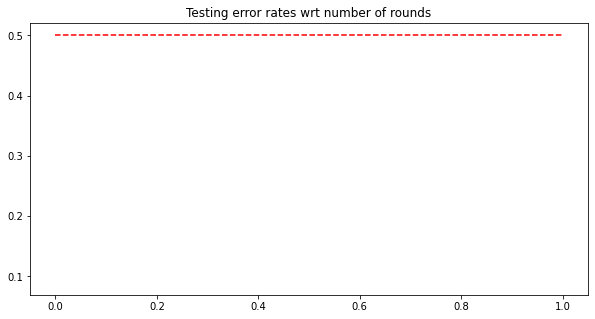

Boosting rounds = : 5
The ROC-AUC score of the model with boosting rounds = 5 is : 0.854
The accuracy score of the model with boosting rounds = 5 is : 0.831
Error rate of final combined classifier: 0.1688


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

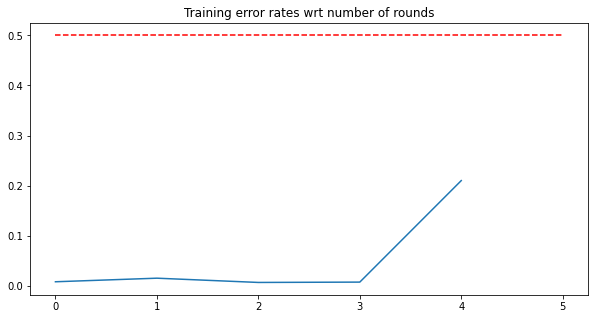

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

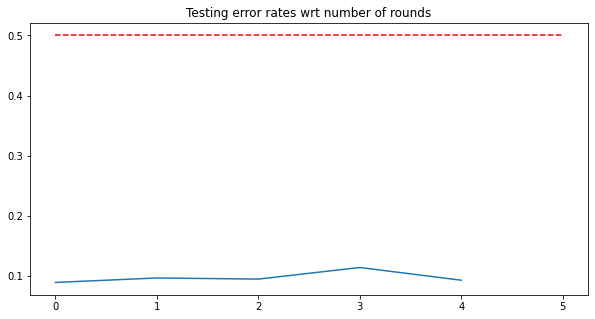

Boosting rounds = : 50
The ROC-AUC score of the model with boosting rounds = 50 is : 0.709
The accuracy score of the model with boosting rounds = 50 is : 0.659
Error rate of final combined classifier: 0.3414


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

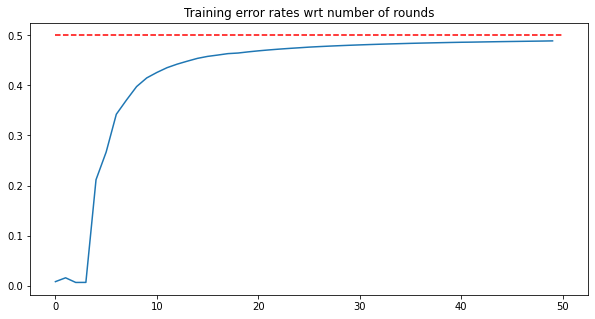

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

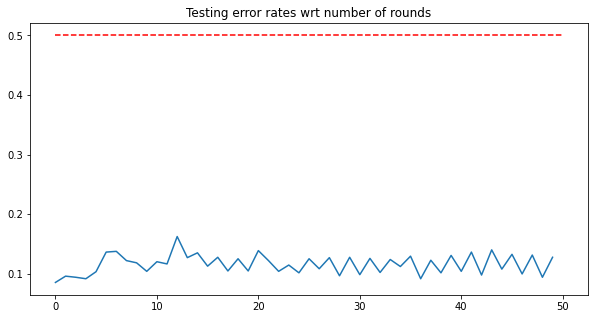

Boosting rounds = : 100
The ROC-AUC score of the model with boosting rounds = 100 is : 0.768
The accuracy score of the model with boosting rounds = 100 is : 0.727
Error rate of final combined classifier: 0.2725


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

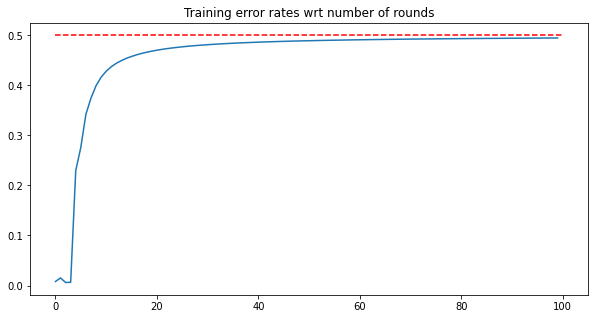

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

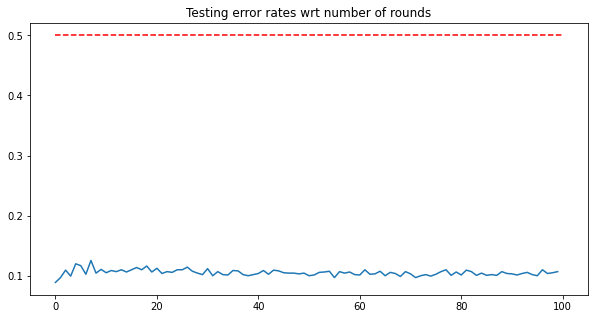

Boosting rounds = : 200
The ROC-AUC score of the model with boosting rounds = 200 is : 0.69
The accuracy score of the model with boosting rounds = 200 is : 0.636
Error rate of final combined classifier: 0.3637


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

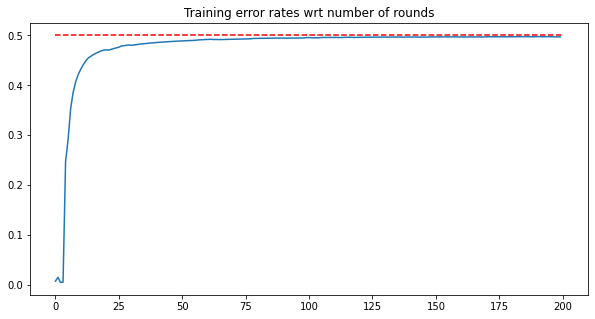

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

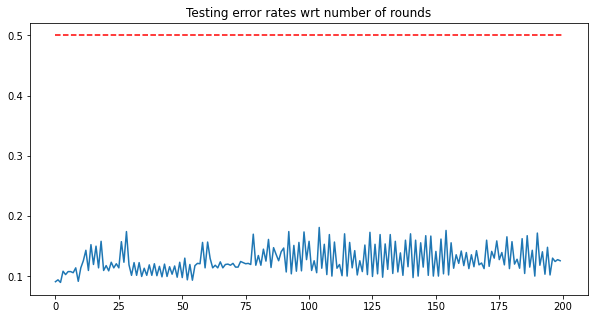

In [52]:
boost_rounds = [1, 5, 50, 100, 200]
max_depth = 20

for i in boost_rounds:
  # Fitting the model for every round value and calculating accuracy score and error rate of final classifier
  print("Boosting rounds = :", i)
  all_clf, train_error, alpha = adaBoost(X_train, y_train, i, max_depth)
  y_pred = predict(X_test, i, all_clf, alpha)
  print('The ROC-AUC score of the model with boosting rounds = {} is : {}'.format(i,round(roc_auc_score(y_test, y_pred), 3)))
  print('The accuracy score of the model with boosting rounds = {} is : {}'.format(i,round(accuracy_score(y_test, y_pred), 3)))
  print('Error rate of final combined classifier:', round(compute_error(y_test, y_pred, np.ones(len(y_test))), 4))

  # Plotting Training error rates for the current round
  plt.figure(figsize=(10,5))
  plt.plot(train_error)
  plt.hlines(0.5, 0, i, colors = 'red', linestyles='dashed')
  plt.title('Training error rates wrt number of rounds')
  plt.show()

  # Plotting Testing error rates for the current round
  plt.figure(figsize=(10,5))
  prediction_errors = error_rates(X_test, y_test, i, all_clf)
  plt.plot(prediction_errors)
  plt.hlines(0.5, 0, i, colors = 'red', linestyles='dashed')
  plt.title('Testing error rates wrt number of rounds')
  plt.show()

#### Experiment 11 - Bagging with Shallow trees (depth = 1)


Bagging rounds = : 1
The ROC-AUC score of the model with bootstrap rounds = 1 is : 0.84
The accuracy score of the model with boosting rounds = 1 is : 0.862


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

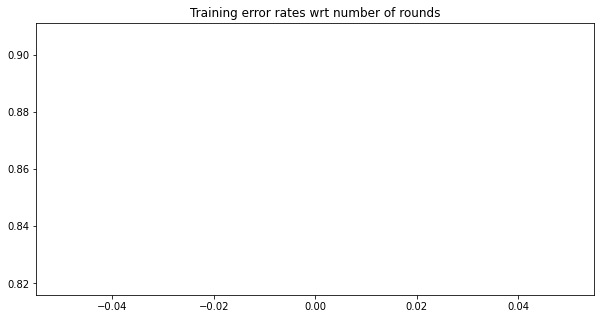

Bagging rounds = : 5
The ROC-AUC score of the model with bootstrap rounds = 5 is : 0.839
The accuracy score of the model with boosting rounds = 5 is : 0.861


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

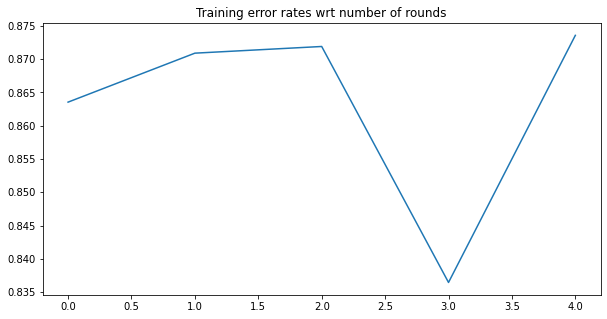

Bagging rounds = : 50
The ROC-AUC score of the model with bootstrap rounds = 50 is : 0.839
The accuracy score of the model with boosting rounds = 50 is : 0.86


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

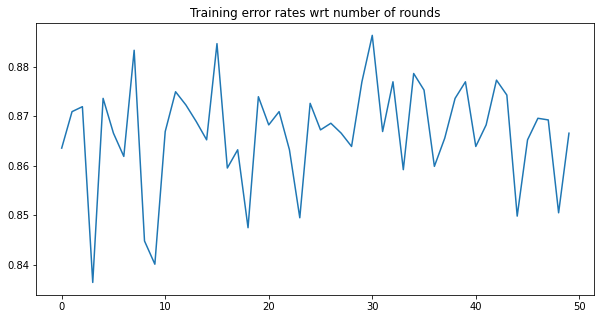

Bagging rounds = : 100
The ROC-AUC score of the model with bootstrap rounds = 100 is : 0.839
The accuracy score of the model with boosting rounds = 100 is : 0.86


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

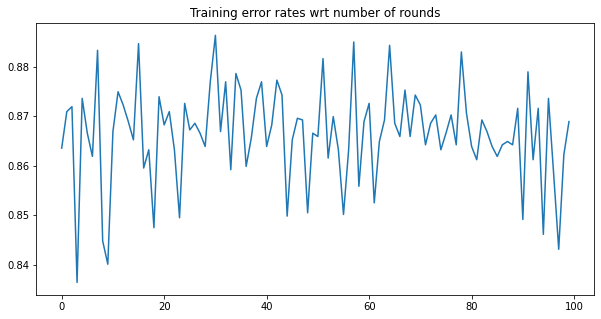

Bagging rounds = : 200
The ROC-AUC score of the model with bootstrap rounds = 200 is : 0.837
The accuracy score of the model with boosting rounds = 200 is : 0.859


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

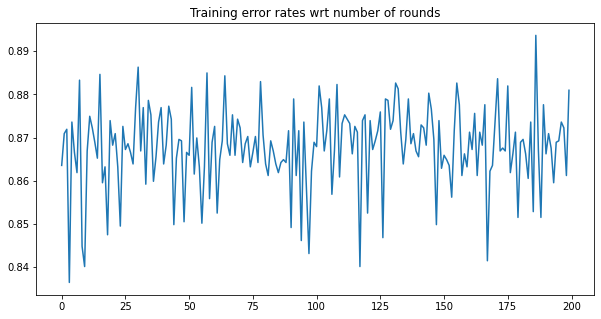

In [53]:
bootstrap_rounds = [1, 5, 50, 100, 200]
max_depth = 1
test_error_total = []

for i in bootstrap_rounds:
    
  # Fitting the model for every round value and calculating accuracy score and error rate of final classifier
  print("Bagging rounds = :", i)
  bagger = baggingAlgo()
  bagger.fit(X_train, y_train, i, max_depth = 2, seed = 123)
  train_error, y_test_hat = bagger.predict(X_test)
  y_test_hat = np.round(y_test_hat,0)
  test_error = predErrorCalc(y_test, y_test_hat)
  print('The ROC-AUC score of the model with bootstrap rounds = {} is : {}'.format(i,round(roc_auc_score(y_test, y_test_hat), 3)))
  print('The accuracy score of the model with boosting rounds = {} is : {}'.format(i,round(accuracy_score(y_test, y_test_hat), 3)))

  # Plotting Training error rates for the current round
  plt.figure(figsize=(10,5))
  plt.plot(train_error)
  plt.title('Training error rates wrt number of rounds')
  plt.show()

  test_error_total.append(test_error)

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

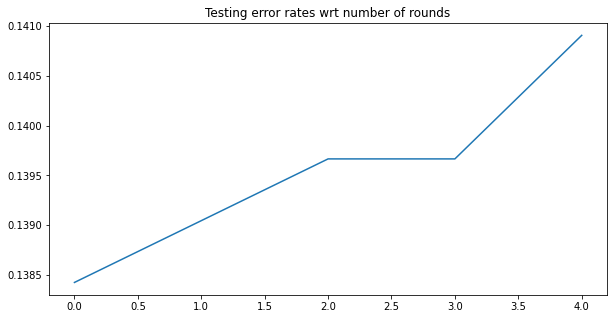

In [54]:
# Plotting Testing error rates for the current round
plt.figure(figsize=(10,5))
# prediction_errors = error_rates(X_test, y_test, i, all_clf)
plt.plot(test_error_total)
# plt.hlines(0.5, 0, boost_rounds, colors = 'red', linestyles='dashed')
plt.title('Testing error rates wrt number of rounds')
plt.show()

#### Experiment 12 - Bagging with Deep trees (depth = 25)

Bagging rounds = : 1
The ROC-AUC score of the model with bootstrap rounds = 1 is : 0.84
The accuracy score of the model with boosting rounds = 1 is : 0.862


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

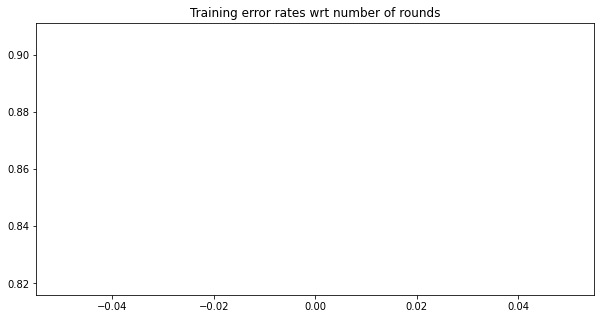

Bagging rounds = : 5
The ROC-AUC score of the model with bootstrap rounds = 5 is : 0.839
The accuracy score of the model with boosting rounds = 5 is : 0.861


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

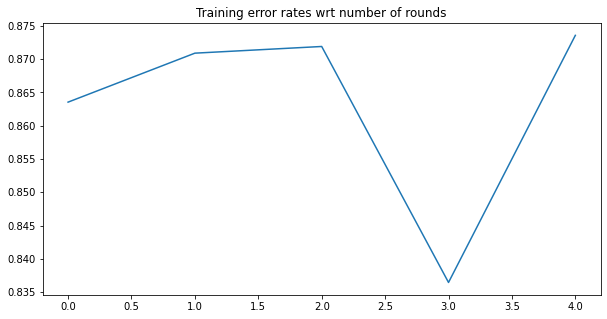

Bagging rounds = : 50
The ROC-AUC score of the model with bootstrap rounds = 50 is : 0.839
The accuracy score of the model with boosting rounds = 50 is : 0.86


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

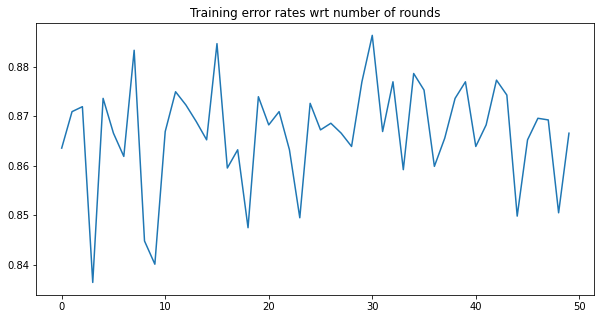

Bagging rounds = : 100
The ROC-AUC score of the model with bootstrap rounds = 100 is : 0.839
The accuracy score of the model with boosting rounds = 100 is : 0.86


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

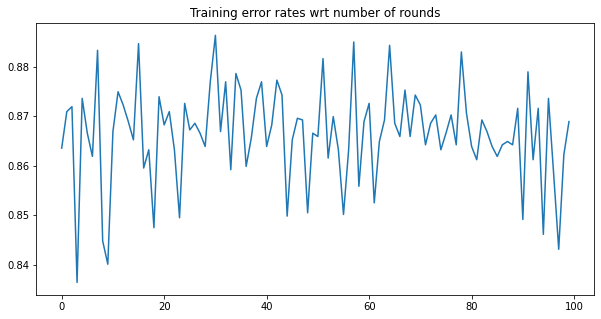

Bagging rounds = : 200
The ROC-AUC score of the model with bootstrap rounds = 200 is : 0.837
The accuracy score of the model with boosting rounds = 200 is : 0.859


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Training error rates wrt number of rounds')

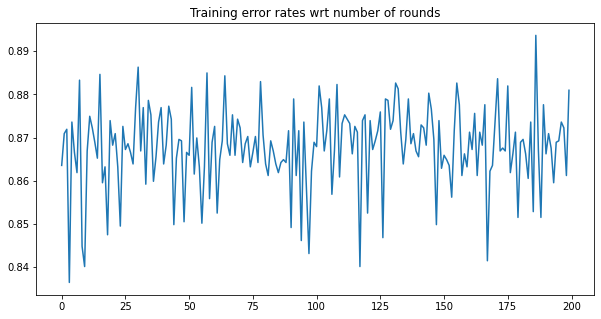

In [55]:
bootstrap_rounds = [1, 5, 50, 100, 200]
max_depth = 25
test_error_total = []

for i in bootstrap_rounds:
    
  # Fitting the model for every round value and calculating accuracy score and error rate of final classifier
  print("Bagging rounds = :", i)
  bagger = baggingAlgo()
  bagger.fit(X_train, y_train, i, max_depth = 2, seed = 123)
  train_error, y_test_hat = bagger.predict(X_test)
  y_test_hat = np.round(y_test_hat,0)
  test_error = predErrorCalc(y_test, y_test_hat)
  print('The ROC-AUC score of the model with bootstrap rounds = {} is : {}'.format(i,round(roc_auc_score(y_test, y_test_hat), 3)))
  print('The accuracy score of the model with boosting rounds = {} is : {}'.format(i,round(accuracy_score(y_test, y_test_hat), 3)))

  # Plotting Training error rates for the current round
  plt.figure(figsize=(10,5))
  plt.plot(train_error)
  plt.title('Training error rates wrt number of rounds')
  plt.show()

  test_error_total.append(test_error)

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Testing error rates wrt number of rounds')

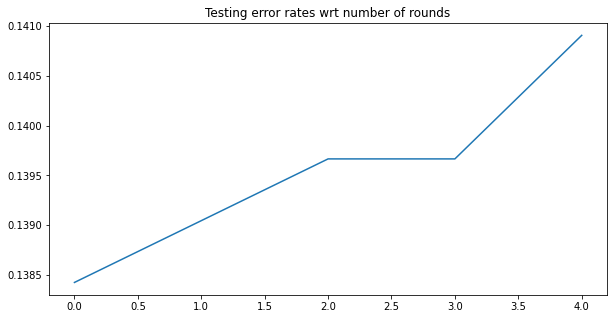

In [56]:
# Plotting Testing error rates for the current round
plt.figure(figsize=(10,5))
# prediction_errors = error_rates(X_test, y_test, i, all_clf)
plt.plot(test_error_total)
# plt.hlines(0.5, 0, boost_rounds, colors = 'red', linestyles='dashed')
plt.title('Testing error rates wrt number of rounds')
plt.show()

#### Decision tree

In [57]:
clf = DecisionTreeClassifier()
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# print("Score:", clf.score(y_test, y_pred))
print("Depth :", clf.get_depth())

Accuracy: 0.9087523277467412
Depth : 31


### Conclusion

From the above expermients, we observe that in terms of Boosting, the performance increases as the depth of the tree increases with increase in number of rounds, depending on the numbers of variables present. Similarly, the perfomance increases as the depth of the tree increases with increase in number of rounds for Bagging. But when we compare Bagging and Boosting, Bagging seems to perform better than Boosting and specifically Bagging with deeper trees and higher number of rounds. We observes trends on these lines in the above experiments. 

Bagging aims to decrease to decrease variance but Boosting aims to reduce bias. Bagging tries to reduce overfitting as the training subsets are randomly drawn with replacement from the entire training dataset but this is not the case with Boosting, as its new subsets contain the elements that were misclassified by previous models. So, if the classifier is unstable (i.e., high variance), then we should apply Bagging. If the classifier is stable and simple (i.e., high bias) then we should apply Boosting.

